In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from tqdm.notebook import tqdm
import optuna
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn import tree
import shap
from xgboost import XGBClassifier
from wordcloud import WordCloud
from utils import preprocess_text,score_extr
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
stop_words.remove('не')
stop_words.remove('из')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cerenov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
stop_words.add('само')

## Data preparation

In [4]:
import spacy
spacy.require_gpu()
nlp = spacy.load('ru_core_news_lg',)

In [5]:
df1 = pd.read_excel('dataset1.xlsx')
df2 = pd.read_excel('dataset2.xlsx')
df3 = pd.read_excel('dataset3.xlsx')
df4 = pd.read_excel('dataset4.xlsx')

In [7]:
df = pd.concat([df1,df2,df3,df4])
del df1,df2,df3,df4

In [8]:
df.head()

,Anime,Rate,Text
0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи..."
1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над..."
2,Мобильный воин Гандам: Единорог / Kidou Senshi...,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х..."
3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...
4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ..."


In [9]:
df.drop_duplicates(subset='Text',inplace=True)
df.dropna(subset='Text',inplace=True)

In [10]:
df.reset_index(drop=True,inplace=True)

In [28]:
df['text'] = df['Text'].apply(preprocess_text)

### Feature engineering

In [18]:
# Заметил, что основная оценка, о том понравилось или не понравилось аниме находится в начале отзыва и в конце. Обрезав текст получил лучше результаты предсказания.
def squeeze_chunk(text):
    words = text.split(' ')
    if len(words) > 512:
        chunk_1 = ' '.join(words[:256])
        chunk_2 = ' '.join(words[-256:])
        return chunk_1 + ' ' + chunk_2
    else:
        return text

In [20]:
mystem = Mystem()
def mystem_lemma(text):
    text = mystem.lemmatize(text)
    text = " ".join([word for word in text if word not in stop_words and word != " " and word.strip() not in string.punctuation])
    return text

In [21]:
def part_of_speach(text):
    document = nlp(text)
    tokens = [token.lemma_ for token in document if token.pos_ in ('ADV,ADJ,VERB,PART,NUM') and token.lemma_ not in stop_words and len(token.lemma_) != 1]
    return " ".join(tokens)

part_of_speach_vect = np.vectorize(part_of_speach)

In [22]:
df['clean_text'] = None

In [29]:
# Извлекаем леммы, количество глаголов,наречий,прилагательных.
lemmas = []
advbs = []
adjs = []
verbs =[]
for doc in nlp.pipe(tqdm(df['text'])):
    tokens = []
    adv = 0
    adj = 0
    verb = 0
    for token in doc:
        token_lemma = token.lemma_
        token_pos = token.pos_
        

        if token_pos in ('ADV,ADJ,VERB,PART,NUM') and token_lemma not in stop_words and len(token_lemma) !=1:
            tokens.append(token_lemma)
            if token_pos == 'ADV':
                adv += 1
            if token_pos == 'ADJ':
                adj += 1
            if token_pos == 'VERB':
                verb += 1
    
    tokens = " ".join(tokens)
    lemmas.append(tokens)
    advbs.append(adv)
    adjs.append(adj)
    verbs.append(verb)

  0%|          | 0/73165 [00:00<?, ?it/s]

In [37]:
df['clean_text'] = lemmas
df['adverbs'] = advbs
df['adjs'] = adjs
df['verbs'] = verbs
df['len_chars'] = df['clean_text'].apply(len) 
df['len_tokens'] = df['clean_text'].str.split(" ").apply(len)

In [ ]:
# Очивидно что самая важная информации о том положительный отзыв или нейтральный находится в таких ключевых слова 7/10, итого 5/10, оцениваю на 3 из 10 и т.д и т.п.
# Написал функцию которая +- вытаскивают это информацию вручную, функция массивная и хрупкая т.к. решал последовательно возвращаясь к необработанным результатам
# там, где маска подтескста не подошла или вовсе нет нумерной оценки проставляется 0.5. Думаю, что если написать качественную функцию,которая учитывает множество вариаций
# можно решить с хорошим качеством данную задачу без применения МО(с учетом того что в большенстве отзывов так или иначе проставлена оценка).
scores = score_extr(df)

In [ ]:
df['score'] = scores

In [33]:
df['squeezed_text'] = df['clean_text'].apply(squeeze_chunk)

In [111]:
# sample = df.loc[200:300,:].copy()
# idxs = sample.index
# for index in idxs:
#     print('----------------')
#     print(f"{df.loc[index,'Rate'].upper()} | Index:{index}")
#     print(df.loc[index,'Text'])
#     print('_____________')
#     print('after cleaning:')
#     print(df.loc[index,'text'])

## Baseline

In [6]:
#df = pd.read_csv('df_clean.csv')

In [7]:
vect = CountVectorizer(min_df=10,ngram_range=(1,2))
corpus = vect.fit_transform(df.squeezed_text)

In [8]:
features_names = vect.get_feature_names_out().tolist()
features_names = features_names + ['adverbs','adjs','verbs','len_chars','len_tokens','score']

In [9]:
# svd = TruncatedSVD(n_components=512,n_iter=10,random_state=42)
# corpus = svd.fit_transform(corpus)
le = LabelEncoder()
target = le.fit_transform(df['Rate'])
x_train,x_val,y_train,y_val = train_test_split(corpus,target,test_size=0.1,random_state=42,stratify=target)
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)

In [54]:
# без использования новых признаков, только слова
rf = RandomForestClassifier(n_jobs=-1,class_weight='balanced')
rf.fit(x_train,y_train)
y_pred = rf.predict(x_val)

In [55]:
print(classification_report(y_val,y_pred,target_names=le.classes_))

               precision    recall  f1-score   support

  Нейтральный       0.44      0.36      0.39      2524
Отрицательный       0.62      0.48      0.54      1788
Положительный       0.56      0.73      0.64      3005

     accuracy                           0.54      7317
    macro avg       0.54      0.52      0.52      7317
 weighted avg       0.53      0.54      0.53      7317



In [10]:
# добавляем признаки
corpus = hstack((corpus,df[['adverbs','adjs','verbs','len_chars','len_tokens','score']].values))

In [11]:
x_train,x_val,y_train,y_val = train_test_split(corpus,target,test_size=0.1,random_state=42,stratify=target)

In [12]:
rf = RandomForestClassifier(n_jobs=-1,class_weight='balanced')
rf.fit(x_train,y_train)
y_pred = rf.predict(x_val)

In [13]:
# видим, что добавление признаков повляло на качество предсказания
print(classification_report(y_val,y_pred,target_names=le.classes_))

               precision    recall  f1-score   support

  Нейтральный       0.45      0.37      0.40      2524
Отрицательный       0.64      0.51      0.57      1788
Положительный       0.57      0.73      0.64      3005

     accuracy                           0.55      7317
    macro avg       0.56      0.54      0.54      7317
 weighted avg       0.55      0.55      0.54      7317



In [63]:
lgbm = LGBMClassifier()
lgbm.fit(x_train.astype(np.float32),y_train,feature_name=features_names,)
y_pred = lgbm.predict(x_val.astype(np.float32))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.493519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 75091
[LightGBM] [Info] Number of data points in the train set: 65848, number of used features: 28544
[LightGBM] [Info] Start training from score -1.064147
[LightGBM] [Info] Start training from score -1.409213
[LightGBM] [Info] Start training from score -0.890032


In [73]:
print(classification_report(y_val,y_pred,target_names=le.classes_))

               precision    recall  f1-score   support

  Нейтральный       0.50      0.45      0.47      2524
Отрицательный       0.64      0.59      0.61      1788
Положительный       0.63      0.72      0.67      3005

     accuracy                           0.59      7317
    macro avg       0.59      0.59      0.59      7317
 weighted avg       0.59      0.59      0.59      7317



In [15]:
cb = CatBoostClassifier(task_type="GPU",verbose=0)
cb.fit(x_train,y_train)
y_pred = cb.predict(x_val)


In [16]:
print(classification_report(y_val,y_pred,target_names=le.classes_))

               precision    recall  f1-score   support

  Нейтральный       0.51      0.44      0.47      2524
Отрицательный       0.64      0.61      0.62      1788
Положительный       0.63      0.72      0.67      3005

     accuracy                           0.59      7317
    macro avg       0.59      0.59      0.59      7317
 weighted avg       0.59      0.59      0.59      7317



## Visualization

In [19]:
rf1 = RandomForestClassifier(n_jobs=-1,class_weight='balanced',max_depth=3,n_estimators=10,max_features=0.1)
rf1.fit(x_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=0.1,
                       n_estimators=10, n_jobs=-1)

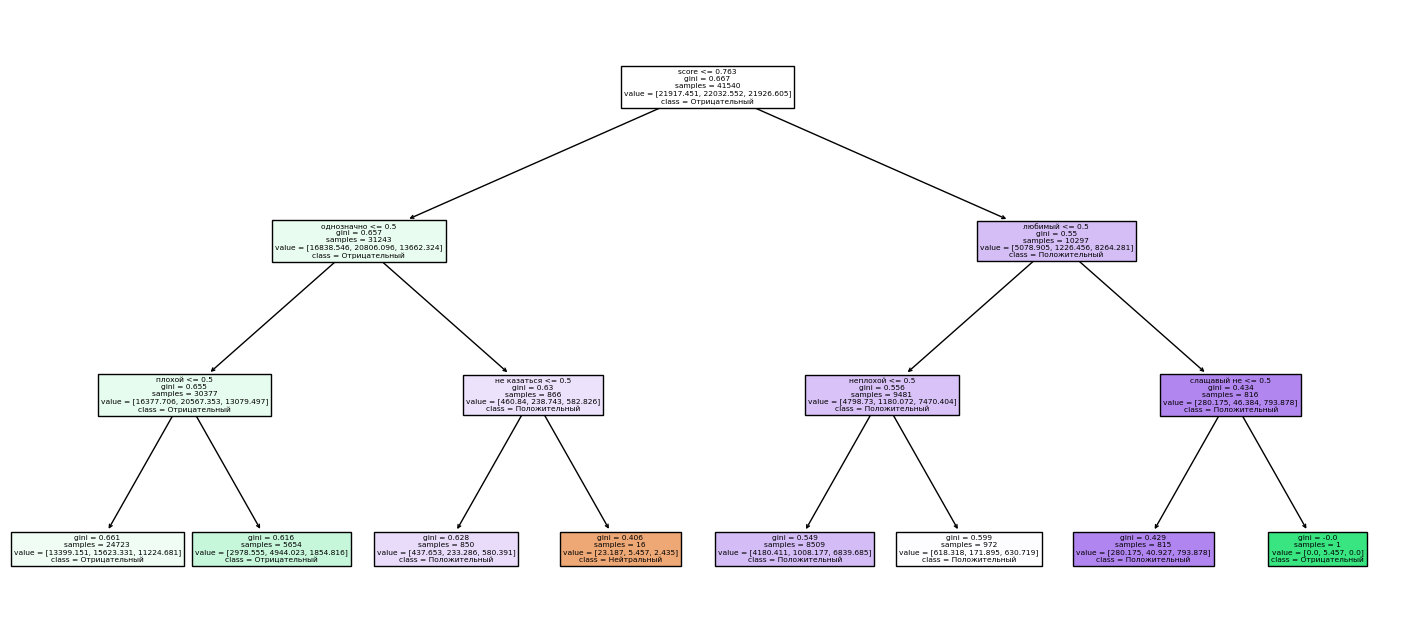

In [21]:
d_tree = rf1.estimators_[0]
plt.figure(figsize = (18,8))
tree.plot_tree(d_tree,feature_names = features_names,class_names=le.classes_,filled = True)
plt.show()

/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


<Axes: >

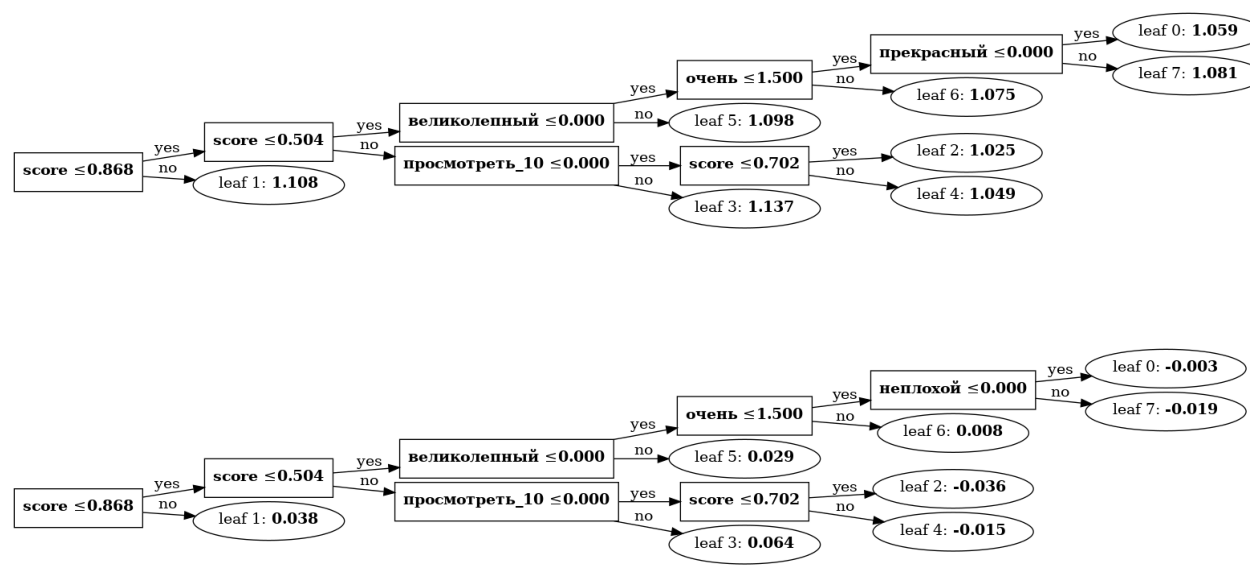

In [82]:
params = {
    "verbose": -1,
    "random_state": 42,
    "n_estimators": 2,
    "num_leaves": 8,
}
lgb_train = lgb.Dataset(x_train,y_train,feature_name=features_names)
lgb_clf = lgb.train(params,lgb_train)
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
lgb.plot_tree(lgb_clf, tree_index=0,dpi=300, ax=ax[0])
lgb.plot_tree(lgb_clf, tree_index=1,dpi=300, ax=ax[1])

In [65]:
_,x,_,y = train_test_split(x_val,y_val,random_state=42,stratify=y_val,test_size=0.2)

### lgbm shap

In [66]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(x.toarray())
expected_values = explainer.expected_value

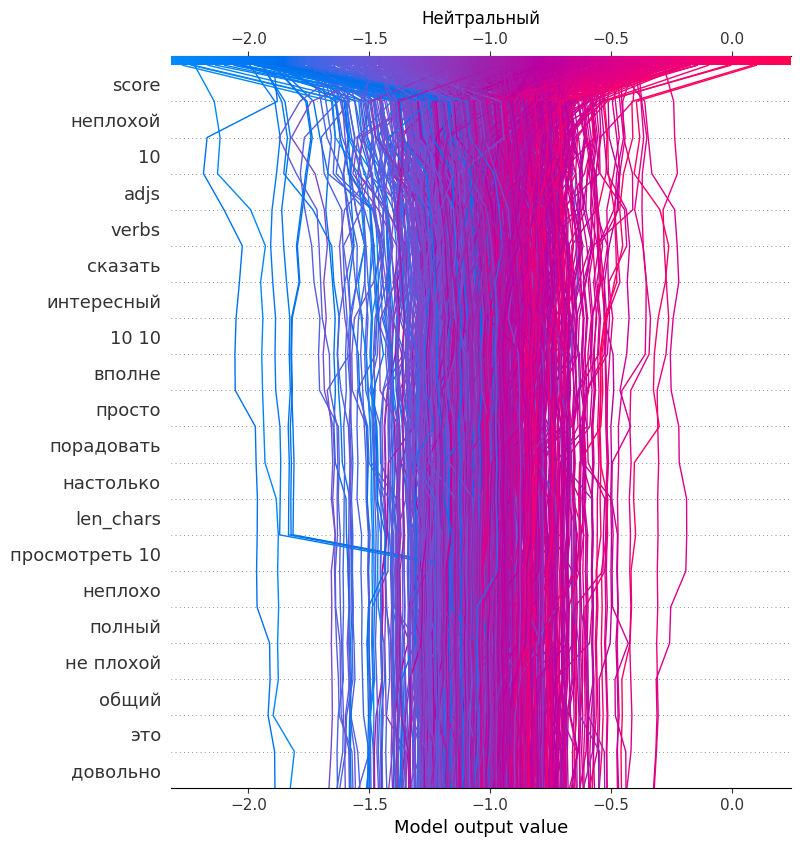

In [67]:
shap.decision_plot(explainer.expected_value[0],shap_values[:,:,0],x.toarray(),feature_names=np.array(features_names),show=True,title=le.classes_[0])

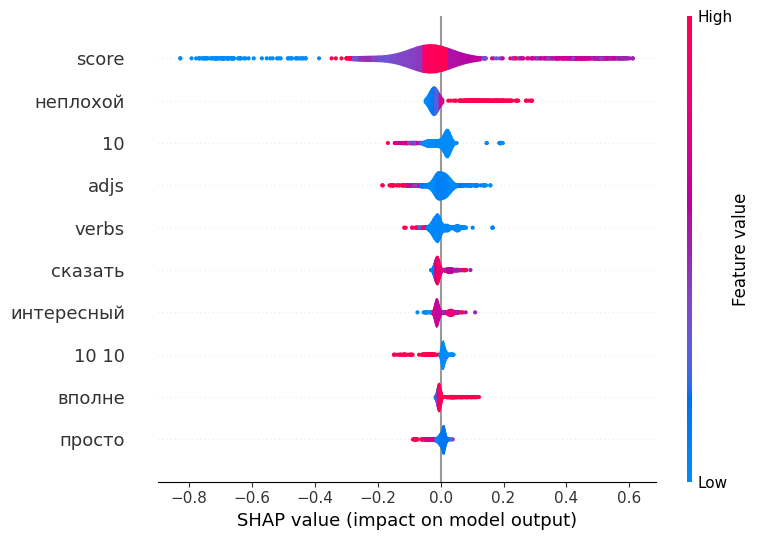

In [68]:
# визуализация для класс Нейтральный
shap.summary_plot(shap_values[:,:,0],x.toarray(),plot_type='violin',feature_names=np.array(features_names),max_display=10,title=le.classes_[0])

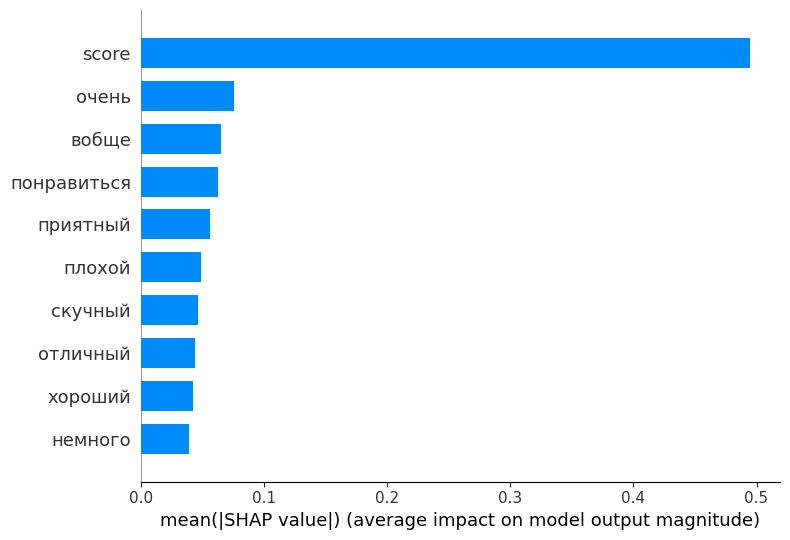

In [70]:
# отрицательный
shap.summary_plot(shap_values[:,:,1],x.toarray(),plot_type='bar',feature_names=np.array(features_names),max_display=10,title=le.classes_[1])

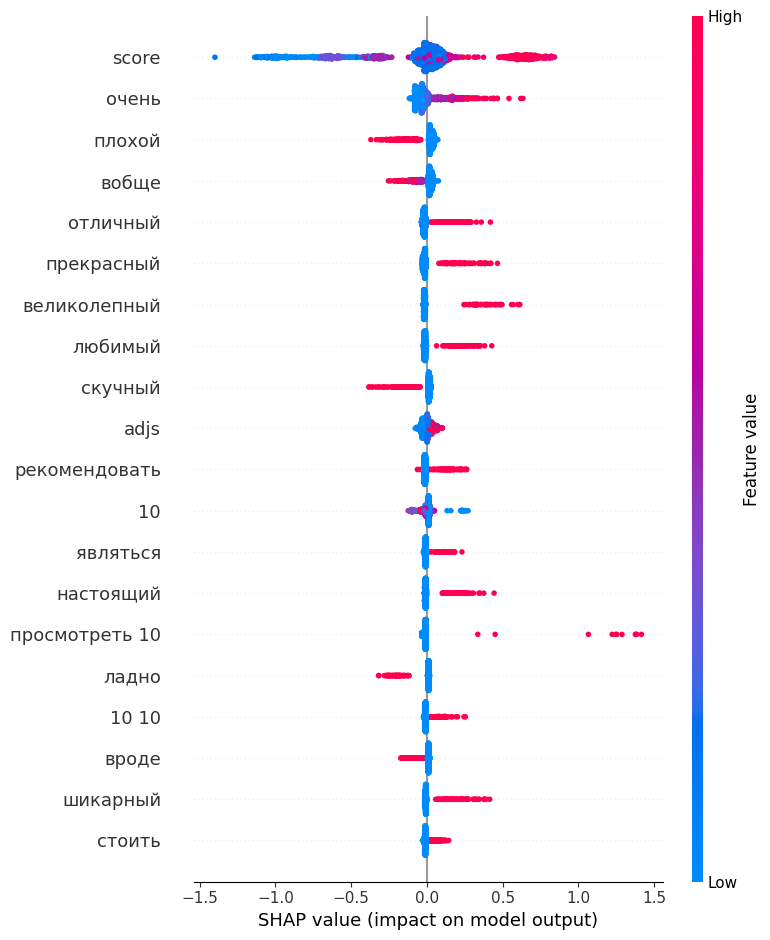

In [76]:
# положительный
shap.summary_plot(shap_values[:,:,2],x.toarray(),feature_names=features_names,title=le.classes_[2])

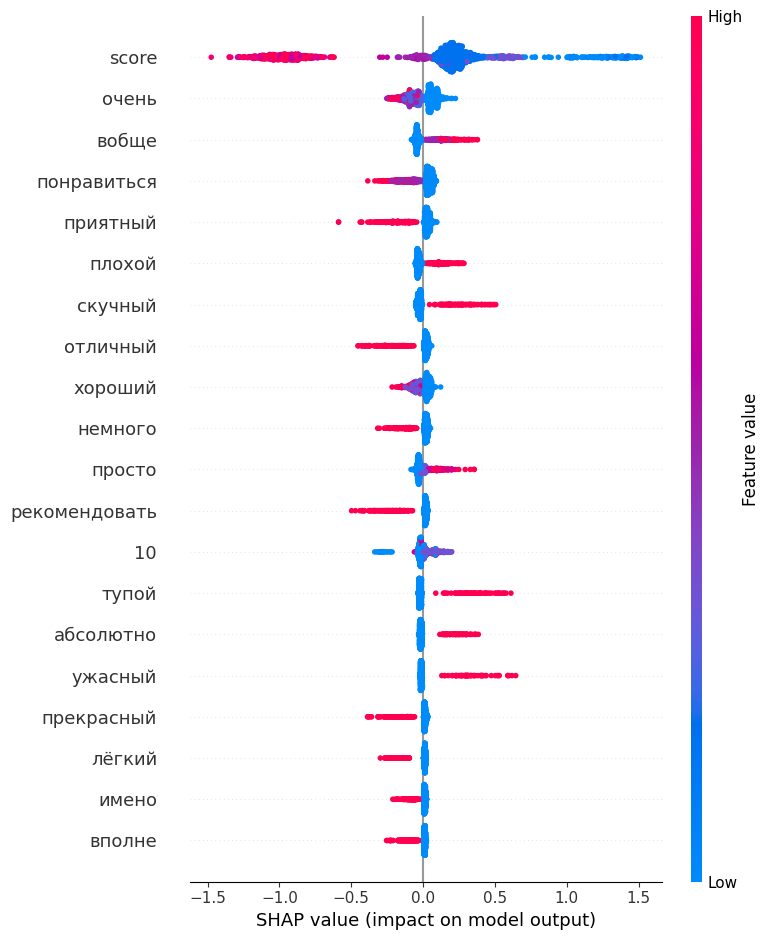

In [77]:
# отрицательный
shap.summary_plot(shap_values[:,:,1],x.toarray(),feature_names=features_names,title=le.classes_[1])

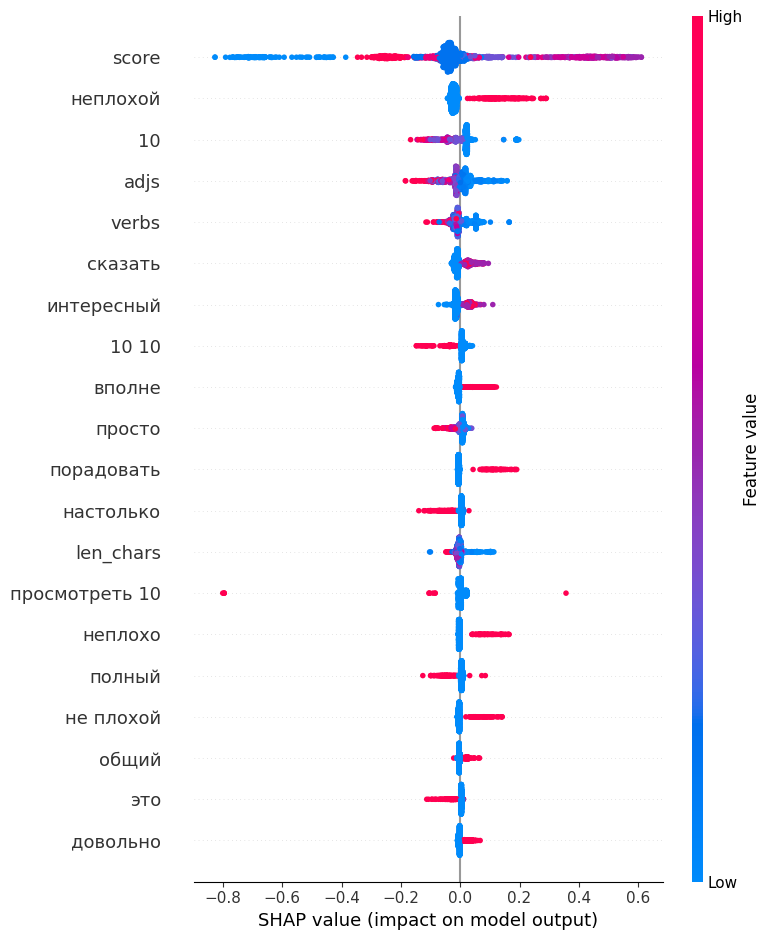

In [78]:
# нейтральный класс
shap.summary_plot(shap_values[:,:,0], x.toarray(),feature_names=features_names,title=le.classes_[0])

Как видим,очивидно,признак score имеет наибольший вес, что было не трудно предсказать. 

### random forest shap

In [83]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x.toarray())
expected_values = explainer.expected_value

In [ ]:
# визуализация для класс Нейтральный
shap.summary_plot(shap_values[:,:,0],x.toarray(),plot_type='violin',feature_names=np.array(features_names),max_display=10,title=le.classes_[0])

In [ ]:
# нейтральный класс
shap.summary_plot(shap_values[:,:,0], x.toarray(),feature_names=features_names,title=le.classes_[0])

In [ ]:
# отрицательный
shap.summary_plot(shap_values[:,:,1],x.toarray(),feature_names=features_names,title=le.classes_[1])

In [ ]:
# положительный
shap.summary_plot(shap_values[:,:,2],x.toarray(),feature_names=features_names,title=le.classes_[2])

## Embedding extraction

In [87]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer

In [113]:
tokenizer = AutoTokenizer.from_pretrained('sismetanin/rubert-ru-sentiment-rusentiment', max_len=512,truncation = True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [115]:
pipe = pipeline('feature-extraction', model='sismetanin/rubert-ru-sentiment-rusentiment',device=device,tokenizer=tokenizer,truncation = True,padding = True)

In [116]:
embeddings = []
for text in tqdm(df['text']):
    output = pipe(text)
    output = np.stack(output)[0]
    output = output.mean(0).reshape(1,-1)
    embeddings.append(output)
embeddings = np.concatenate(embeddings)

  0%|          | 0/73165 [00:00<?, ?it/s]

Сдавливаем матрицу corpus, теряем информацию, ради эффективности.

In [22]:
svd = TruncatedSVD(512,random_state=42,n_iter=10)
squeezed_data = svd.fit_transform(corpus)
embeddings = np.load('emb.npy')

In [57]:
# добавляем эмбеддинги
X = np.concatenate([squeezed_data,embeddings],axis = 1)
#X = hstack((corpus,embeddings))

In [58]:
X = np.concatenate([X,df[['adverbs','adjs','verbs','len_chars','len_tokens','score']].values],axis=1)

In [59]:
# балансируем данные
pos = df[df['Rate'] == 'Положительный'].sample(17000).index
neutral = df[df['Rate'] == 'Нейтральный'].sample(17000).index
neg = df[df['Rate'] == 'Отрицательный'].index

In [60]:
indexes = np.concatenate([pos,neutral,neg])

In [61]:
scaler = StandardScaler()

In [62]:
X = X[indexes,:]
Y = target[indexes]

In [63]:
x_train,x_val,y_train,y_val = train_test_split(X,Y,stratify=Y,random_state=42,test_size=0.1,shuffle=True)

In [64]:
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### Ensemble models

In [49]:
cb_params ={
    'learning_rate': 0.01457936761005562, 
    'depth': 6, 
    'min_data_in_leaf': 18, 
    'iterations': 4866, 
    'max_bin': 256,
    'reg_lambda': 1.02382186306887,
    'random_state':42
    }
xgb_params = {
    'lambda': 0.023674715515207456, 
    'alpha': 0.5805719046581088, 
    'colsample_bytree': 0.5, 
    'subsample': 0.8, 
    'learning_rate': 0.03631952533204157, 
    'n_estimators': 490, 
    'max_depth': 7, 
    'random_state': 2024, 
    'min_child_weight': 100
    }

In [65]:
cb = CatBoostClassifier(task_type='GPU',verbose=0)
cb.fit(x_train,y_train)
y_pred = cb.predict(x_val)

In [66]:
print(classification_report(y_val,y_pred,target_names=le.classes_))

               precision    recall  f1-score   support

  Нейтральный       0.49      0.42      0.45      1700
Отрицательный       0.67      0.75      0.70      1788
Положительный       0.62      0.63      0.62      1700

     accuracy                           0.60      5188
    macro avg       0.59      0.60      0.59      5188
 weighted avg       0.59      0.60      0.59      5188



In [67]:
lgbm = LGBMClassifier(verbose = 0)
lgbm.fit(x_train.astype(np.float32),y_train)
y_pred = lgbm.predict(x_val.astype(np.float32))
print(classification_report(y_val,y_pred,target_names=le.classes_))

               precision    recall  f1-score   support

  Нейтральный       0.48      0.41      0.44      1700
Отрицательный       0.66      0.75      0.70      1788
Положительный       0.61      0.62      0.61      1700

     accuracy                           0.59      5188
    macro avg       0.58      0.59      0.59      5188
 weighted avg       0.59      0.59      0.59      5188



In [68]:
xgbc = XGBClassifier(device='cuda:0',)
xgbc.fit(x_train,y_train)
y_pred = xgbc.predict(x_val)
print(classification_report(y_val,y_pred,target_names=le.classes_))

               precision    recall  f1-score   support

  Нейтральный       0.46      0.42      0.44      1700
Отрицательный       0.66      0.72      0.69      1788
Положительный       0.61      0.60      0.61      1700

     accuracy                           0.58      5188
    macro avg       0.58      0.58      0.58      5188
 weighted avg       0.58      0.58      0.58      5188



In [69]:
xgbc = XGBClassifier(device='cuda:0',**xgb_params)
lgbm = LGBMClassifier(verbose = 0)
cb = CatBoostClassifier(task_type='GPU',verbose=0)
vclf = VotingClassifier(estimators=[('cb',cb),('xgb',xgbc),('lgbm',lgbm)],voting='soft')
vclf = vclf.fit(x_train,y_train)

In [70]:
y_pred = vclf.predict(x_val)
print(classification_report(y_val,y_pred,target_names=le.classes_))

               precision    recall  f1-score   support

  Нейтральный       0.49      0.42      0.46      1700
Отрицательный       0.66      0.75      0.70      1788
Положительный       0.63      0.63      0.63      1700

     accuracy                           0.60      5188
    macro avg       0.60      0.60      0.60      5188
 weighted avg       0.60      0.60      0.60      5188



Ансамбль может различать классы Отрицательный от Положительный но с Нейтральным плохо справляется,скорее всего из за того,что сам по себе класс неоднозначен, плюс шумы в данных и неверные метки.

In [103]:
# drop_index = [0,]
# positive_to_neutral = [2]
# neutral_to_positive = [13,44]
# neutral_to_negative = [47]
# несколько меток которые были найдены при первом взгляде
print(df.loc[2,'Rate'])
print('----------')
print(df.loc[2,'Text'])
print('______________-')
print(df.loc[13,'Rate'])
print('--------------')
print(df.loc[13,'Text'])

Положительный
----------
Что тут сказать? Никакого сравнени я с Seed, хоть и пытается ему подражать... Банаджер вообще не выдерживает никакого сравнения с обаятельным, харизматичным, молчаливым Кирой, а надутая принцесса - с бешеной Кагалли.Конечно, тут есть и свой "человек в маске", и даже не без обаяния, но Господи... кто придумал рисовать его разжиревшим философом в странной одежде, да еще и заставить его говорить голосом Председателя? Куда делась вся элегантность, красота, изящная рисовка? Неведомо. Безусловно, я могу быть предвзятым - все же я поклонник вселенной Киры/Асурана, а не Галактического века. Есть и тут хорошие вещи, к примеру картинка, пусть и здорово потеряла в стиле, выглядит отлично, а анимация и постановка боев - просто шикарны! Из персонажей порадовала разве что рыжая девушка-пилот из Зиона.Да, и кстати - длительность серий поначалу вызывает легкий шок...ОБщая оценка - 5 из 10. Не шмогла.
______________-
Нейтральный
--------------
Потрясающе! Начиная смотреть, даже

## BERTopic

In [38]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

2024-08-07 10:08:47.598739: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 10:08:47.703273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 10:08:47.751129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 10:08:47.763567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 10:08:47.836914: I tensorflow/core/platform/cpu_feature_guar

In [73]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [74]:
embedding_model = SentenceTransformer("ai-forever/sbert_large_nlu_ru")

In [90]:
topic_model = BERTopic(embedding_model = embedding_model, calculate_probabilities=True,verbose=False,min_topic_size = 5,n_gram_range = (1,2))
topics,probs = topic_model.fit_transform(df[df['Rate'] == 'Положительный'].sample(17000)['squeezed_text'])

In [92]:
fig = topic_model.visualize_barchart(top_n_topics=10)
fig.show()

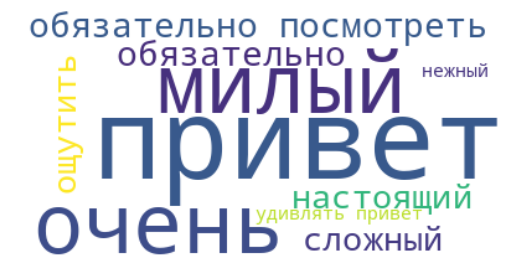

In [93]:
create_wordcloud(topic_model, topic=1)

In [94]:
topic_model_neg = BERTopic(embedding_model = embedding_model, calculate_probabilities=True,verbose=False,min_topic_size = 5,n_gram_range = (1,2))
topics,probs = topic_model_neg.fit_transform(df[df['Rate'] == 'Отрицательный'].sample(17000)['squeezed_text'])


In [96]:
fig = topic_model_neg.visualize_barchart(top_n_topics=10)
fig.show()

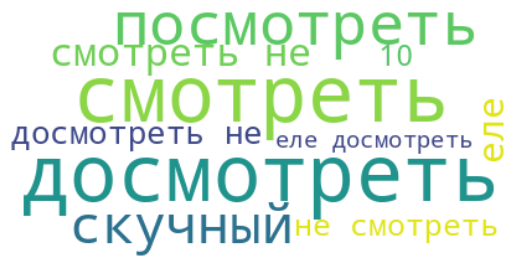

In [95]:
create_wordcloud(topic_model_neg, topic=1)

In [97]:
topic_model_neu = BERTopic(embedding_model = embedding_model, calculate_probabilities=True,verbose=False,min_topic_size = 5,n_gram_range = (1,2))
topics,probs = topic_model_neu.fit_transform(df[df['Rate'] == 'Нейтральный'].sample(17000)['squeezed_text'])


In [100]:
fig = topic_model_neu.visualize_barchart(top_n_topics=10)
fig.show()

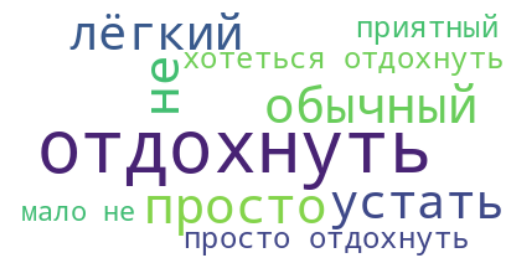

In [99]:
create_wordcloud(topic_model_neu, topic=1)

## Вывод

Градиентный бустинг и Случайный лес +- обращают внимание на одни важные признаки. Бустинг показывает в среднем лучше результаты, работает быстрее за счет GPU. Тематические моделирование по подклассам показало,что модели классификации обращают внимания на те же слова, что ожидаемо.
Что можно было сделать:
    * Скрупулезно и тщательно предобработать текст с учетом того, что мы работаем имеено с деревьями.
    * Использовать разные способы и модели эмбеддингов(например использвать максимум вместо среднего), проверить что лучше работает.
    * Создать больше признаков (например выделить описательные токены в категории) думаю,что это сильно повляет на качество.
    * Проверить разные способы уменьшения размерности.
    

## Hyperparameters search

### XGB

In [101]:
def objective(trial):
    param = {
        'device':'cuda:0',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0,log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0,log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        'n_estimators' : trial.suggest_int("n_estimators", 100,500, step = 10),
        'max_depth': trial.suggest_int('max_depth',5,15),
        'random_state': trial.suggest_categorical('random_state', [2024,42]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBClassifier(**param)  
    
    model.fit(x_train,y_train,eval_set = [(x_val,y_val)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(x_val)
    
    score = accuracy_score(y_val,preds)
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials = 50,show_progress_bar = True)

[I 2024-08-07 10:57:21,162] A new study created in memory with name: no-name-533b72a1-f807-4f83-a631-bebf9750c0f7


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-08-07 10:57:35,722] Trial 0 finished with value: 0.5765227447956823 and parameters: {'lambda': 0.01892432818107625, 'alpha': 0.028978754316150445, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.009205718404659799, 'n_estimators': 170, 'max_depth': 11, 'random_state': 42, 'min_child_weight': 174}. Best is trial 0 with value: 0.5765227447956823.
[I 2024-08-07 10:58:06,209] Trial 1 finished with value: 0.5932922127987664 and parameters: {'lambda': 0.01609967310468819, 'alpha': 6.927226816578598, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.02752603867278175, 'n_estimators': 360, 'max_depth': 8, 'random_state': 2024, 'min_child_weight': 120}. Best is trial 1 with value: 0.5932922127987664.
[I 2024-08-07 10:58:20,899] Trial 2 finished with value: 0.5969545104086353 and parameters: {'lambda': 0.0021994540462429487, 'alpha': 4.516824318482565, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.16232458154415672, 'n_estimators': 160, 'max_dept

KeyboardInterrupt: 

### RandomForest

In [ ]:
def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 200, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # Create and fit random forest model
    model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42,
    )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    score = accuracy_score(y_val,y_pred)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials = 50,show_progress_bar = True)

### LGBM

In [ ]:
def objective(trial):
    params = {
        'device_type':'gpu',
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = LGBMClassifier(**params)
    model.fit(x_train, y_train)
    predictions = model.predict(x_val)
    score = accuracy_score(y_val, predictions)
    return score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30,show_progress_bar=True)

In [166]:
import gc
torch.cuda.empty_cache()
gc.collect()

493

### CatBoost

In [20]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        'iterations':trial.suggest_int('iterations',2000,6000),
        'max_bin':trial.suggest_int('max_bin',60,600,1),
        'reg_lambda':trial.suggest_float('reg_lambda',1.0,13),
        'random_state':42,
        'task_type':'GPU',
        "used_ram_limit": "14gb",
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_val)
    score = accuracy_score(y_val,predictions)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30,show_progress_bar=True)

[I 2024-08-06 20:18:54,968] A new study created in memory with name: no-name-992c633b-0595-4a1a-a572-5acde305886d


  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_10804/843784776.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_bin':trial.suggest_int('max_bin',60,600,1),


[I 2024-08-06 20:20:06,856] Trial 0 finished with value: 0.612567463377024 and parameters: {'learning_rate': 0.0381673519641299, 'depth': 3, 'min_data_in_leaf': 46, 'iterations': 4329, 'max_bin': 539, 'reg_lambda': 1.0794619109974253}. Best is trial 0 with value: 0.612567463377024.


/tmp/ipykernel_10804/843784776.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_bin':trial.suggest_int('max_bin',60,600,1),


[I 2024-08-06 20:20:39,326] Trial 1 finished with value: 0.600231303006939 and parameters: {'learning_rate': 0.012817666957977302, 'depth': 2, 'min_data_in_leaf': 61, 'iterations': 3288, 'max_bin': 489, 'reg_lambda': 9.633102420168553}. Best is trial 0 with value: 0.612567463377024.


/tmp/ipykernel_10804/843784776.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_bin':trial.suggest_int('max_bin',60,600,1),


[I 2024-08-06 20:21:09,273] Trial 2 finished with value: 0.6044718581341557 and parameters: {'learning_rate': 0.014429495050325885, 'depth': 4, 'min_data_in_leaf': 44, 'iterations': 2501, 'max_bin': 136, 'reg_lambda': 4.608011126216887}. Best is trial 0 with value: 0.612567463377024.


/tmp/ipykernel_10804/843784776.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_bin':trial.suggest_int('max_bin',60,600,1),


[I 2024-08-06 20:21:29,820] Trial 3 finished with value: 0.5869313801079414 and parameters: {'learning_rate': 0.0042686073050074436, 'depth': 2, 'min_data_in_leaf': 79, 'iterations': 3159, 'max_bin': 189, 'reg_lambda': 11.739501880768685}. Best is trial 0 with value: 0.612567463377024.


/tmp/ipykernel_10804/843784776.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_bin':trial.suggest_int('max_bin',60,600,1),


[I 2024-08-06 20:23:38,119] Trial 4 finished with value: 0.6160370084811102 and parameters: {'learning_rate': 0.0637545707037137, 'depth': 5, 'min_data_in_leaf': 54, 'iterations': 3114, 'max_bin': 471, 'reg_lambda': 9.134270019586948}. Best is trial 4 with value: 0.6160370084811102.


/tmp/ipykernel_10804/843784776.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_bin':trial.suggest_int('max_bin',60,600,1),


[I 2024-08-06 20:49:23,329] Trial 5 finished with value: 0.6015805705474171 and parameters: {'learning_rate': 0.0026696979704949773, 'depth': 8, 'min_data_in_leaf': 51, 'iterations': 5510, 'max_bin': 522, 'reg_lambda': 2.779386075552297}. Best is trial 4 with value: 0.6160370084811102.


/tmp/ipykernel_10804/843784776.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_bin':trial.suggest_int('max_bin',60,600,1),


[I 2024-08-06 20:52:38,012] Trial 6 finished with value: 0.5946414803392444 and parameters: {'learning_rate': 0.0020904790302492854, 'depth': 5, 'min_data_in_leaf': 9, 'iterations': 5877, 'max_bin': 376, 'reg_lambda': 3.063487938700999}. Best is trial 4 with value: 0.6160370084811102.


/tmp/ipykernel_10804/843784776.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_bin':trial.suggest_int('max_bin',60,600,1),


[I 2024-08-06 20:53:51,023] Trial 7 finished with value: 0.5925212027756361 and parameters: {'learning_rate': 0.004635635696081516, 'depth': 6, 'min_data_in_leaf': 41, 'iterations': 2099, 'max_bin': 190, 'reg_lambda': 1.565536797594142}. Best is trial 4 with value: 0.6160370084811102.


/tmp/ipykernel_10804/843784776.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_bin':trial.suggest_int('max_bin',60,600,1),


[I 2024-08-06 21:25:15,211] Trial 8 finished with value: 0.616615265998458 and parameters: {'learning_rate': 0.014387910713333198, 'depth': 9, 'min_data_in_leaf': 14, 'iterations': 4921, 'max_bin': 377, 'reg_lambda': 5.244728433232332}. Best is trial 8 with value: 0.616615265998458.


/tmp/ipykernel_10804/843784776.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_bin':trial.suggest_int('max_bin',60,600,1),


[W 2024-08-06 21:26:42,701] Trial 9 failed with parameters: {'learning_rate': 0.01457936761005562, 'depth': 6, 'min_data_in_leaf': 18, 'iterations': 4866, 'max_bin': 256, 'reg_lambda': 1.02382186306887} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_10804/843784776.py", line 15, in objective
    model.fit(x_train, y_train)
  File "/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/catboost/core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages/catboost/core.py", line 2400, in _fit
    self._train(
  File "/home/cerenov/anaconda3/envs/kaggle/lib/python3.10/site-packages

KeyboardInterrupt: 